In [1]:
%matplotlib inline

import math
import os
import cv2
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Cropping2D, Lambda
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpim

Using TensorFlow backend.
/home/ryan/anaconda3/envs/carnd-odlab/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ryan/anaconda3/envs/carnd-odlab/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ryan/anaconda3/envs/carnd-odlab/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ryan/

In [109]:
samples = get_samples_list('samples', ['3'], (20, 50))

In [123]:
print(len(samples))

142


In [108]:
def get_samples_list(sampledir, exclude=[], d_range=[]):
#     samples = [(os.path.join(sampledir, fname), int(fname[0])) \
#                for fname in os.listdir(sampledir) \
#                if fname[-4:]=='.png' and not fname[0] in exclude]
    samples = []
    for fname in os.listdir(sampledir):
        if fname[-4:]=='.png' and not fname[0] in exclude:
            d = int(fname.split('__')[-1].split('_')[0])
            if len(d_range) > 0 and (d < d_range[0] or d > d_range[1]):
                continue
            samples.append((os.path.join(sampledir, fname), int(fname[0])))
    
    return samples

def datagen(samples, batch_size=32, n_class=4):
    n_samples = len(samples)
    while True:
        samples = shuffle(samples)
        for offset in range(0, n_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            labels = []
            for batch_sample in batch_samples:
                im = mpim.imread(batch_sample[0])
                images.append(im)
                labels.append(batch_sample[1])
                
            images = np.array(images)
            labels = keras.utils.to_categorical(np.array(labels), num_classes=n_class)
            
            yield shuffle(images, labels)

In [124]:
def net_nvidia(n_class=4):
    model = Sequential()
    
    # input processing
    
    # normalise
#     model.add(AveragePooling2D(input_shape=(600, 800, 3)))
#     model.add(Lambda(lambda x: (x/255)-0.5))
    model.add(Lambda(lambda x: (x/255)-0.5, input_shape=(600, 800, 3)))
    
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2)))
    model.add(Activation('relu')) # the paper doesn't mention activation function, but isn't that needed?
    
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2)))
    model.add(Activation('relu')) 
    
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2)))
    model.add(Activation('relu')) 
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Activation('relu')) 
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Dropout(0.30))
    model.add(Activation('relu')) 
    
    model.add(Flatten())
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    
    model.add(Dense(50))
    model.add(Activation('relu'))
    
    model.add(Dense(10))
    model.add(Activation('relu'))
    
    model.add(Dense(n_class))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [52]:
def net_simple(n_class=4):
    model = Sequential()
    
#     model.add(Lambda(lambda x: x[::2, ::2, :], input_shape=(600, 800, 3)))
#     model.add(Flatten())
    model.add(AveragePooling2D(input_shape=(600, 800, 3)))
    model.add(Flatten())
#     model.add(Flatten(input_shape=(600, 800, 3)))
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    
    model.add(Dense(10))
    model.add(Activation('relu'))
    
    model.add(Dense(n_class))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [125]:
def train(model, sample_dir='./samples', batch_size=8, epochs=1):
    samples = get_samples_list(sample_dir, exclude=['3'])
    train_samples, valid_samples = train_test_split(samples, test_size=0.25)
    train_gen = datagen(train_samples, batch_size=batch_size, n_class=3)
    valid_gen = datagen(valid_samples, batch_size=batch_size, n_class=3)
    
    train_step = math.ceil(len(train_samples)/batch_size)
    valid_step = math.ceil(len(valid_samples)/batch_size)
    
    print(train_step, valid_step)
    
    history = model.fit_generator(train_gen, steps_per_epoch=train_step,
                                  validation_data=valid_gen, validation_steps=valid_step,
                                  epochs=epochs, verbose=1)
    model.save('model.h5')
    return history

In [129]:
model = net_nvidia(n_class=3)
# model = net_simple(n_class=3)
h = train(model, batch_size=32)

14 5
Epoch 1/1
14/14 [==============================] - 131s - loss: 1.0508 - acc: 0.4419 - val_loss: 0.8048 - val_acc: 0.4094


In [54]:
h2 = train(model, batch_size=16, epochs=9)

28 10
Epoch 1/9
28/28 [==============================] - 16s - loss: 1.0837 - acc: 0.5389 - val_loss: 1.0768 - val_acc: 0.5101
Epoch 2/9
28/28 [==============================] - 15s - loss: 1.0697 - acc: 0.5373 - val_loss: 1.0656 - val_acc: 0.4698
Epoch 3/9
28/28 [==============================] - 16s - loss: 1.0563 - acc: 0.5386 - val_loss: 1.0489 - val_acc: 0.5503
Epoch 4/9
28/28 [==============================] - 15s - loss: 1.0436 - acc: 0.5386 - val_loss: 1.0353 - val_acc: 0.5101
Epoch 5/9
28/28 [==============================] - 16s - loss: 1.0318 - acc: 0.5395 - val_loss: 1.0345 - val_acc: 0.4631
Epoch 6/9
28/28 [==============================] - 16s - loss: 1.0206 - acc: 0.5380 - val_loss: 1.0112 - val_acc: 0.5638
Epoch 7/9
28/28 [==============================] - 18s - loss: 1.0101 - acc: 0.5373 - val_loss: 1.0069 - val_acc: 0.4765
Epoch 8/9
28/28 [==============================] - 17s - loss: 1.0000 - acc: 0.5380 - val_loss: 0.9982 - val_acc: 0.5503
Epoch 9/9
28/28 [=========

In [133]:
samples = get_samples_list('samples', exclude=['3'])
samples_gen = datagen(samples, batch_size=32, n_class=3)

In [134]:
imgs, labels = next(samples_gen)
preds = model.predict(imgs, len(imgs), verbose=0)
print(preds.shape)
for pred, label in zip(preds, labels):
    print(label, pred)

(32, 3)
[0. 0. 1.] [0.40913832 0.04403131 0.54683036]
[1. 0. 0.] [0.40912685 0.04400844 0.54686475]
[1. 0. 0.] [0.4091778  0.04411608 0.5467061 ]
[1. 0. 0.] [0.409168   0.04409086 0.5467411 ]
[1. 0. 0.] [0.4091267  0.04400842 0.5468648 ]
[1. 0. 0.] [0.40916845 0.04408741 0.54674417]
[1. 0. 0.] [0.4091357  0.04403087 0.5468334 ]
[1. 0. 0.] [0.40918326 0.04412923 0.5466875 ]
[0. 0. 1.] [0.40915045 0.04405985 0.5467897 ]
[1. 0. 0.] [0.40917465 0.04410916 0.5467162 ]
[1. 0. 0.] [0.40912685 0.04400844 0.5468647 ]
[0. 0. 1.] [0.40913752 0.04403084 0.54683167]
[1. 0. 0.] [0.40916982 0.04409243 0.5467378 ]
[0. 0. 1.] [0.40914044 0.04403364 0.546826  ]
[0. 0. 1.] [0.40916544 0.04408395 0.5467506 ]
[0. 0. 1.] [0.40915447 0.04406713 0.54677844]
[1. 0. 0.] [0.40917403 0.04410399 0.546722  ]
[0. 0. 1.] [0.4090975  0.04394811 0.5469544 ]
[1. 0. 0.] [0.40917385 0.04410424 0.54672194]
[1. 0. 0.] [0.40913865 0.04403748 0.5468239 ]
[1. 0. 0.] [0.40916914 0.04408742 0.54674345]
[1. 0. 0.] [0.40912864 0.0

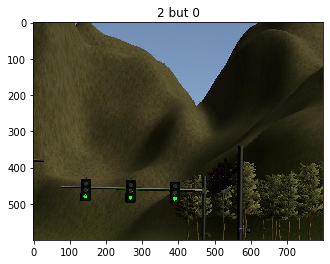

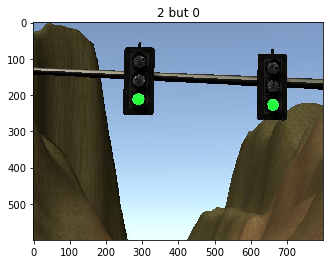

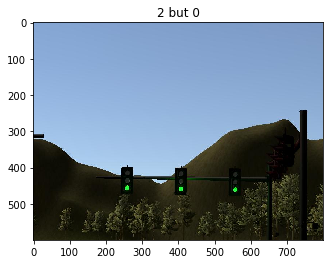

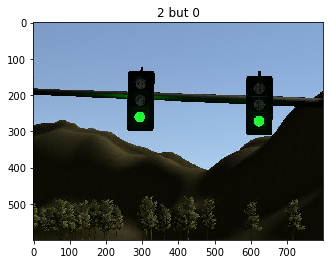

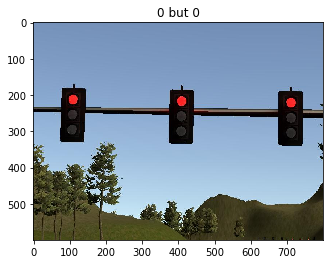

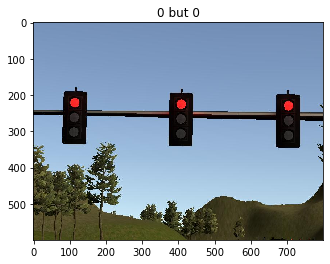

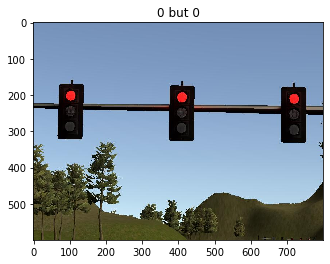

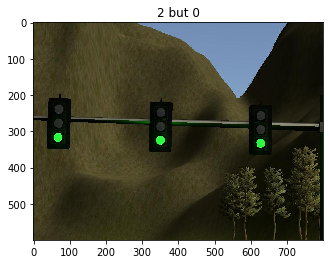

In [43]:
for img, label, pred in zip(imgs, labels, preds):
    plt.figure()
    plt.imshow(img)
    plt.gca().set_title('{} but {}'.format(np.argmax(label), np.argmax(pred)))